# Samples for MusicVAE and Miditok

In [2]:
import miditoolkit
from miditoolkit import MidiFile, notes2pianoroll
from miditok import (REMI, CPWord, Event, MIDILike, MIDITokenizer, MuMIDI,
                     OctupleMono)

path_midi = miditoolkit.midi.utils.example_midi_file()
midi = MidiFile(path_midi)

In [15]:
from typing import List
from src.tokenizers import get_tokenizer_params, split_to_chunk

tokenizer = REMI()
tokens = tokenizer.midi_to_tokens(midi)[0]

print(len(tokens))

2404


<AxesSubplot:>

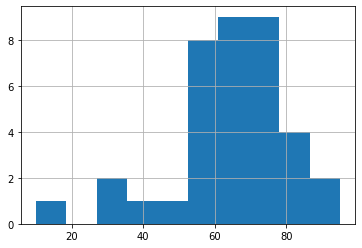

In [18]:
import pandas as pd

tokens_split = split_to_chunk(tokens, tokenizer)
pd.Series([len(l) for l in tokens_split]).hist()

In [32]:
split_midi = tokenizer.tokens_to_midi([tokens_split[1]])

In [33]:
from src.utils import miditoolkit_to_notesequence
from note_seq import plot_sequence

plot_sequence(miditoolkit_to_notesequence(midi))
plot_sequence(miditoolkit_to_notesequence(split_midi))

Loading BokehJS ...

Loading BokehJS ...